# Continuous Delivery with Jenkins in Kubernetes Engine

# GSP 051

<div style="width: 400px;">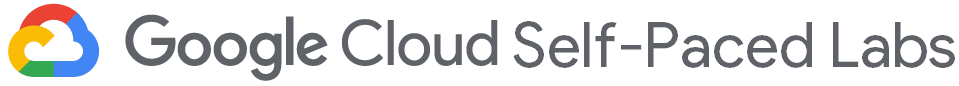</div>

[퀵랩 사이트](https://qwiklabs.com/focuses/7046)

## 1. Overview

   * 쿠베에서 젠키스 배포 파이프라인 설치 및 설정

  * 쿠베에서 젠킨스 환경
  * [참조: Jenkins on Kubernetes Engine](https://cloud.google.com/solutions/jenkins-on-kubernetes-engine)
  
<div style="width: 800px"><center>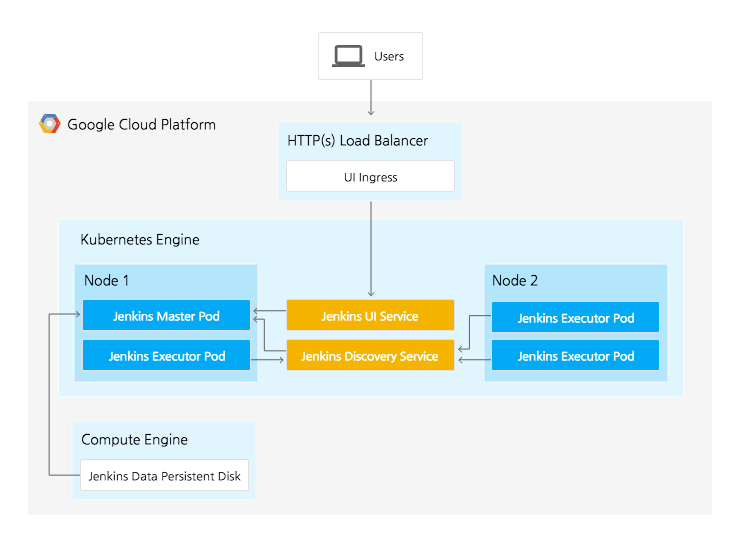</center></div>

### 해야 할 것들

   * 쿠베엔진 클러스터에서 젠킨스 준비
   * 젠킨스 시스템 설정
       * Configuration file, credential, namespace, load balancing
   * 젠킨스 실습
   * 젠킨스 파이프라인 예제

### 필요지식

   * 최소 선수과목 이수
      * [Introduction to Docker](https://google.qwiklabs.com/focuses/7010)
      * [Hello Node Kubernetes](https://google.qwiklabs.com/focuses/5734)
   * Linux System Admin 숙련도
   * DevOpt: Continuous Delivery / Continuous Deployment
   * 젠킨스 친숙도

**주의: 서비스를 생성하고 배포하면, 다음 단계로 가기전에 반드시 지시서에 설명하듯이 실행되고 있는지 확인하시오!!!!!**

## 2. Kubernetes Engine 란?

   * Kubernetes 의 hosted version
   * 클러스터를 관리하고, 컨테이너들의 오케스트레이팅 하는 시스템

## 3. Jenkins 란

   * 오픈소스
   * 시스템을 빌드, 테스트, 배포 파이브라인을 유연하게 오케스트레이팅 하는 도구 

## 4. Continuous Delivery / Continuous Deployment 란 ?

   * Continuous Delivery(CD) 를 셋업해야 하는 경우, 쿠베 엔진 상에 젠킨슨을 놓으면 표준 VM-기반 개발에서 많은 좋은점이 있다.
   
   
   * 빌드 프로세스가 컨테이너를 이용하면, 여러 다른 운영환경에 대표해서 하나의 가상 호스트에서 작업을 수행합니다.
   * 쿠베 엔진은 이전 빌드 환경과 동일한 환경을 제공하여 빌드를 할 수 있도록 합니다.
   * 쿠베 엔진은 빌드가 활발하게 실행 중일때만 리소스를 리소스를 이용하고, 레버리지가 가능하도록합니다.
   
   
   * 빌드를 젠킨스 상에서 클릭하면, 쿠베 엔진은 구글 글로벌 로드 밸런서를 활용하여 웹트레픽을 사용자 인스탄트에 라우팅 합니다.
   * 로드 밸런서는 SSL 종단을 처리하고, 구글 글로벌 백본 네트워크를 통해 사용자에게 가장 가까운 곳으로 부터 가장 빠른 경로중 하나로 사용자를 웹 프론트 엔드로 라우팅 하는 글로벌 IP 주소를 제공합니다.


## 5. Practice 시작

## 5.1 셋업

  * 퀵랩과 구글 계정 연결에 대한 설정및 활성화(Activate) (생략)
  * 클라우드 쉘과 연결후에 다음을 확인

**\#1. 인증확인**

gcloud auth list  
<hr/>  

     Credentialed Accounts  
ACTIVE  ACCOUNT  
&ast;       riveroaks.jung@gmail.com  
To set the active account, run:  
    $ gcloud config set account \`ACCOUNT\`

**\#2. 프로젝트 확인**  
gcloud config list project
***

\[core\]  
project = jenkins-kube-195808  
Your active configuration is: \[cloudshell-21069\]

만일 프로젝트가 설정이 안되어 있으면
gcloud config **set** project &lt;PROJECT_ID &gt;

그럼 결과가 다음처럼 나옵니다.  
Update property \[core/project\]


## 5.1 레포지터리 복사

github.com 에서 Jenkins 학습용 자료 복사

**#3. zone 설정**  
gcloud config set compute/zone us-central1-f
***
Updated property \[compute/zone\].


**#4. git clone 실행**  
git clone https://github.com/GoogleCloudPlatform/continuous-deployment-on-kubernetes.git  
***


Cloning into 'continuous-deployment-on-kubernetes'...  
remote: Counting objects: 690, done.  
remote: Compressing objects: 100% (3/3), done.  
remote: Total 690 (delta 2), reused 1 (delta 1), pack-reused 686  
Receiving objects: 100% (690/690), 1.11 MiB | 332.00 KiB/s, done.  
Resolving deltas: 100% (355/355), done.  

**#5. 작업폴더로 이동**  
cd continuous-deployment-on-kubernetes
***

**#6. 편의상 프롬프트 짧게 설정**  
PS1='[\${PWD##*/}\]$ '

## 5.2 젠킨스 준비

### 5.2.1 쿠베 클러스터 생성

**#7. scope behavior field 설정. 클러스터 설정시 Warning 제거용**  
gcloud config set container/new_scopes_behavior true
***
Updated property \[container/new_scopes_behavior\].

**#8. Compute Engine network 생성**  
gcloud compute networks create jenkins --subnet-mode auto
***
API \[compute.googleapis.com\] not enabled on project \[338302313343\].  
Would you like to enable and retry?  (y/N)?  y  
Enabling service compute.googleapis.com on project 338302313343...  
Waiting for async operation operations/tmo-acf.d7714dac-ddd1-4463-bfd3-73f5b72f4e39 to complete...  
Operation finished successfully. The following command can describe the Operation details:  
 gcloud services operations describe operations/tmo-acf.d7714dac-ddd1-4463-bfd3-73f5b72f4e39  
Created \[https://www.googleapis.com/compute/v1/projects/jenkins-kube-195808/global/networks/jenkins\].


NAME&nbsp;&nbsp;&nbsp;&nbsp; SUBNET_MODE&nbsp; BGP_ROUTING_MODE&nbsp;&nbsp;&nbsp;  IPV4_RANGE&nbsp;&nbsp;&nbsp;  GATEWAY_IPV4  
jenkins&nbsp;&nbsp;&nbsp;&nbsp; AUTO&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; REGIONAL  


Instances on this network will not be reachable until firewall rules  
are created. As an example, you can allow all internal traffic between  
instances as well as SSH, RDP, and ICMP by running:  



\$ gcloud compute firewall-rules create <FIREWALL_NAME> --network jenkins --allow tcp,udp,icmp --source-ranges  <IP_RANGE>  
\$ gcloud compute firewall-rules create <FIREWALL_NAME> --network jenkins --allow tcp:22,tcp:3389,icmp
***
**Networks list**  
gcloud compute networks list  

|NAME   |  SUBNET_MODE | BGP_ROUTING_MODE | IPV4_RANGE  |GATEWAY_IPV4 ||  
|-------|--------------|------------------|-------------|-------------|
|default|  AUTO        | REGIONAL         |             |             ||  
|jenkins|  AUTO        | REGIONAL         |             |             ||  

**#9. Kube cluster 생성**  
gcloud container clusters create jenkins-cd --num-nodes 5 --network jenkins --scopes "https://www.googleapis.com/auth/projecthosting,storage-rw"  
***
ERROR: (gcloud.container.clusters.create) ResponseError: code=403, message=The Kubernetes Engine API is not enabled for p
roject jenkins-kube-195808. Please ensure it is enabled in the Google Cloud Console at https://console.cloud.google.com/apis/api/container.googleapis.com/overview?project=jenkins-kube-195808 and try again.
***
**API Activate 생성후 다시 실행**
***
Creating cluster jenkins-cd...done.  
Created \[https://container.googleapis.com/v1/projects/jenkins-kube-195808/zones/us-central1-f/clusters/jenkins-cd\].  
To inspect the contents of your cluster, go to: https://console.cloud.google.com/kubernetes/workload_/gcloud/us-central1-f/jenkins-cd?project=jenkins-kube-195808  
kubeconfig entry generated for jenkins-cd.  
<pre>NAME        LOCATION       MASTER_VERSION  MASTER_IP      MACHINE_TYPE   NODE_VERSION  NUM_NODES  STATUS</pre>
<pre>jenkins-cd  us-central1-f  1.8.7-gke.1     35.188.98.217  n1-standard-1  1.8.7-gke.1   5          RUNNING</pre>

**#10. Confirm cluster is running**  
gcloud container clusters list  
***
<pre>NAME        LOCATION       MASTER_VERSION  MASTER_IP      MACHINE_TYPE   NODE_VERSION  NUM_NODES  STATUS</pre>
<pre>jenkins-cd  us-central1-f  1.8.7-gke.1     35.188.98.217  n1-standard-1  1.8.7-gke.1   5          RUNNING</pre>

**#11. Check connect to the cluster**  
kubectl cluster-info
***
Kubernetes master is running at https://35.188.98.217  
GLBCDefaultBackend is running at https://35.188.98.217/api/v1/namespaces/kube-system/services/default-http-backend/proxy  
Heapster is running at https://35.188.98.217/api/v1/namespaces/kube-system/services/heapster/proxy  
KubeDNS is running at https://35.188.98.217/api/v1/namespaces/kube-system/services/kube-dns/proxy  
kubernetes-dashboard is running at https://35.188.98.217/api/v1/namespaces/kube-system/services/kubernetes-dashboard/proxy  


To further debug and diagnose cluster problems, use 'kubectl cluster-info dump'.

### 5.2.2 Jenkins home Volume 생성

   * 제공된 jenkins 설정파일을 이용하기 위해서 제공한 tarball 을 이용하여 jenkins home volume 을 생성합니다.
   
**#12. jekins image volume 생성**  
gcloud compute images create jenkins-home-image --source-uri https://storage.googleapis.com/solutions-public-assets/jenkins-cd/jenkins-home-v3.tar.gz
***
Created \[https://www.googleapis.com/compute/v1/projects/jenkins-kube-195808/global/images/jenkins-home-image\].  
<pre>NAME                PROJECT              FAMILY  DEPRECATED  STATUS</pre>
<pre>jenkins-home-image  jenkins-kube-195808                      READY</pre>

**#13. image volume mount**  
gcloud compute disks create jenkins-home --image jenkins-home-image --zone us-central1-f
***
Created \[https://www.googleapis.com/compute/v1/projects/jenkins-kube-195808/zones/us-central1-f/disks/jenkins-home\].  
<pre>NAME          ZONE           SIZE_GB  TYPE         STATUS</pre>
<pre>jenkins-home  us-central1-f  10       pd-standard  READY</pre>

### 5.2.3 Jenkins credentials 설정

**#14. 임의 비빌번호 생성하여 option file 에 갱신**  
export PASSWORD=\`openssl rand -base64 15\`; echo "Your password is \$PASSWORD"; sed -i.bak s#CHANGE_ME#$PASSWORD# jenkins/k8s/options
***
Your password is XXXXXXXXXXXXXXXXXXXX

**#15. Jenkins 용 Kubernetes namespace 를 생성**  
kubectl create ns jenkins
***
namespace "jenkins" created



\[참조\] namespace 는 multiple environment 환경에서 유일한 resource 를 정의하지 않아도 리소스 메니페스트를 통하여 관리를 하도록 합니다. 

**#16. Kubertenetes 용 [secret](https://kubernetes.io/docs/concepts/configuration/secret/) 를 생성합니다.**  
kubectl create secret generic jenkins --from-file=jenkins/k8s/options --namespace=jenkins
***
secret "jenkins" created

### 5.2.4 Jenkins 배포(Deploy)

이 절에선 jenkins/k8s 폴더에 정의된 sample code 를 이용하여 **deployment** 하고 **service** 를 생성합니다.

kubectl apply: Jenkins container 와 Jenkins home directory 를 포함한 disk 를 갖는 deployment 를 생성합니다.


kubectl apply: Jenkins master 가 다른 pods 에 접근할 수 있는 두개의 서비스 생성
   * [NodePort service](https://kubernetes.io/docs/concepts/services-networking/service/#type-nodeport): 
        * port 8080
        * pods 와 외부사용자가 Jenkins-UI 접근하는 서비스
        * HTTP LoadBalancer 에 의해서 load balanced 된다.
   * [ClusterIP service](https://kubernetes.io/docs/concepts/services-networking/service/#publishing-services---service-types): 
        * port 50000
        * Jenkins executor 가 내부에서 Jenkins master 와 통신하는 서비스
   
**#17. Jenkins deployment 와 service 를 생성합니다.**  
kubectl apply -f jenkins/k8s/
***
deployment "jenkins" created  
service "jenkins-ui" created  
service "jenkins-discovery" created

**#18. pods 가 실행중인지 확인 합니다.**  
STATUS 컬럼이 running 이 나올때 까지 계속 확인 합니다. STATUS 가 Running 나와야 다음 단계로 진행 할 수 있습니다.  


kubectl get pods -n jenkins
***
<pre>NAME                      READY     STATUS    RESTARTS   AGE</pre>
<pre>jenkins-87c47bbb8-4smvh   0/1       <B>Running</B>   0          1m</pre>


### 5.2.5 HTTP Load Balancing  설정

[ingress resource](https://kubernetes.io/docs/concepts/services-networking/ingress/) 를 생성 할 것입니다. 
   * ingress 는 Jenkins UI 서비스의 external load balancing 을 관리합니다. 
   * SSL 종단으로 역활을 하여 사용자와 Jenkins UI 사이의 SSL 통신을 하도록 서비스 합니다.
   
**#19. 서비스 들이 실행하고 있는지 확인 합니다.**   
다음과 같은 결과가 안나오면 계속 반복 실행해서 확인합니다.  

kubectl get svc -n jenkins
***
<pre>NAME                TYPE        CLUSTER-IP      EXTERNAL-IP   PORT(S)          AGE</pre>
<pre>jenkins-discovery   ClusterIP   10.11.252.220   &lt;none&gt;        50000/TCP        12m</pre>
<pre>jenkins-ui          NodePort    10.11.251.109   &lt;none&gt;        8080:30850/TCP   12m</pre>

**#20. SSL 인증서와 키를 생성합니다.**  
openssl req -x509 -nodes -days 365 -newkey rsa:2048 -keyout /tmp/tls.key -out /tmp/tls.crt -subj "/CN=jenkins/O=jenkins"
***
Generating a 2048 bit RSA private key  
................................................................+++  
..........................+++  
writing new private key to '/tmp/tls.key'  
\-----  

**#21. 인증서를 Kubernetes 에 [secret](https://kubernetes.io/docs/concepts/configuration/secret/) 으로 올립니다.**  
kubectl create secret generic tls --from-file=/tmp/tls.crt --from-file=/tmp/tls.key -n jenkins
***
secret "tls" created

**#22. [ingress](https://kubernetes.io/docs/concepts/services-networking/ingress/) 를 사용하여 HTTP load balancer 를 생성합니다.**  
kubectl apply -f jenkins/k8s/lb/ingress.yaml
***
ingress "jenkins" created

### 5.2.6 Jenkins 에 접속

Load Balancer 의 상태를 확인합니다. **backends** 항목이 **UNKNOWN** 또는 **UNHEALTH** 상태에서 **HEALTHY** 상태로 바뀌어야 다음을 진행 할 수 있습니다. 이것은 약 10-15분 정도 시간이 걸립니다.

**#23. Load Balancer 상태 확인** 
kubectl describe ingress jenkins --namespace jenkins
***
<pre>
Name:             jenkins
Namespace:        jenkins
Address:          35.227.249.151
Default backend:  jenkins-ui:8080 (10.8.0.5:8080)
TLS:
  tls terminates
Rules:
  Host  Path  Backends
  ----  ----  --------
  *     *     jenkins-ui:8080 (10.8.0.5:8080)
Annotations:
  https-target-proxy:     k8s-tps-jenkins-jenkins--49bbc424f59f9e87
  target-proxy:           k8s-tp-jenkins-jenkins--49bbc424f59f9e87
  ssl-cert:               k8s-ssl-jenkins-jenkins--49bbc424f59f9e87
  static-ip:              k8s-fw-jenkins-jenkins--49bbc424f59f9e87
  url-map:                k8s-um-jenkins-jenkins--49bbc424f59f9e87
  backends:               {"k8s-be-30850--49bbc424f59f9e87":<B>"Unknown"</B>}  <B>Unknown 이 HEALTHY 로 바뀜</B>
  forwarding-rule:        k8s-fw-jenkins-jenkins--49bbc424f59f9e87
  https-forwarding-rule:  k8s-fws-jenkins-jenkins--49bbc424f59f9e87
Events:
  Type    Reason   Age              From                     Message
  ----    ------   ----             ----                     -------
  Normal  ADD      2m               loadbalancer-controller  jenkins/jenkins
  Normal  CREATE   1m               loadbalancer-controller  ip: 35.227.249.151
  Normal  Service  1m (x3 over 1m)  loadbalancer-controller  default backend set to jenkins-ui:30850
</pre>

**. 일단 backend 항목이 HEALTHY 로 상태가 바뀌면 다음 명령어를 이용하여 url 과 password 정보를 얻습니다.**  

**#24. URL 정보**  
echo "Jenkins URL: https://`kubectl get ingress jenkins -n jenkins -o jsonpath='{.status.loadBalancer.ingress[0].ip}'`";
***
Jenkins URL: https://35.227.249.151

**#25. Password 정보**  
echo "Your username/password: jenkins/\$PASSWORD"
***
Your username/password: jenkins/XXXXXXXXXXX

**#26. URL 정보와 비빌번호을 이용하여 접속합니다.**  


 처음 접속하면 SSL unsafe 화면이 나타납니다. ADVANCED 를 클릭하면 Unsafe 진행 이라는 것이 나타나면 그것을 클릭합니다. 그림에서 빨간박스 부분.  
 
 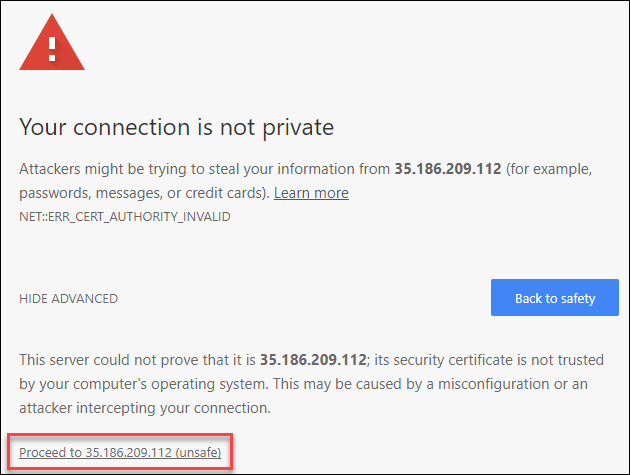

위 빨간 박스를 클릭하면  다음과 같은 메인화면이 나타납니다.

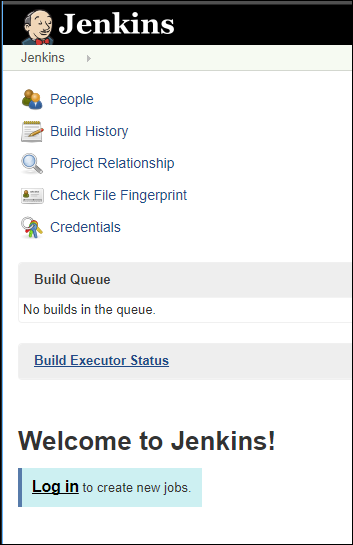

## 5.3 Application  이해

   * 이제 간단한 Sample Application 을 Jenkins pipeline 을 이용해 배포(deploy) 할 것입니다.
   * Sample Application 을 Go 언어로 작성되었으며, sample-app 폴더에 있습니다.
   * 실행하면 다음과 같은 정보가 나옵니다. (go run main.go html.go)
   
   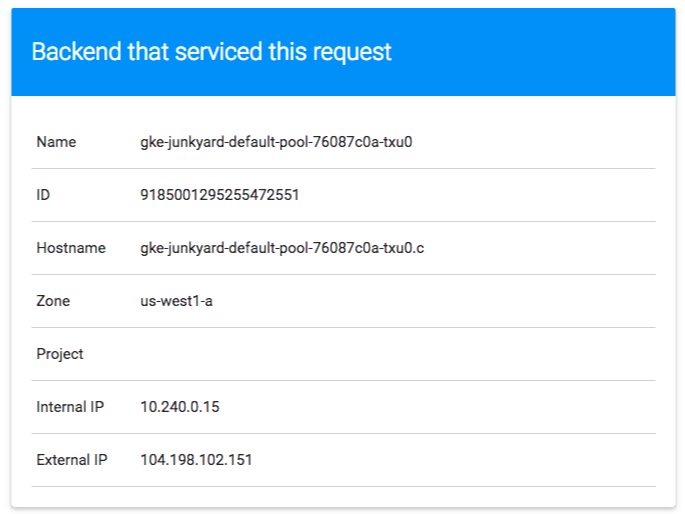

   * 샘플 프로그램은 다음 2가지 모드를 지원하면서 microservice 를 흉내냅니다.
       * backend mode: port 8080 에서 listen 하며, Compute Engine Metadata 를 JSON 형태로 보냅니다.
       * frontend mode: gceme 가 backend gceme 서비스로 query 를 보내고, 사용자 인터페이스에서 JSON  결과를 렌더링 합니다.
       
 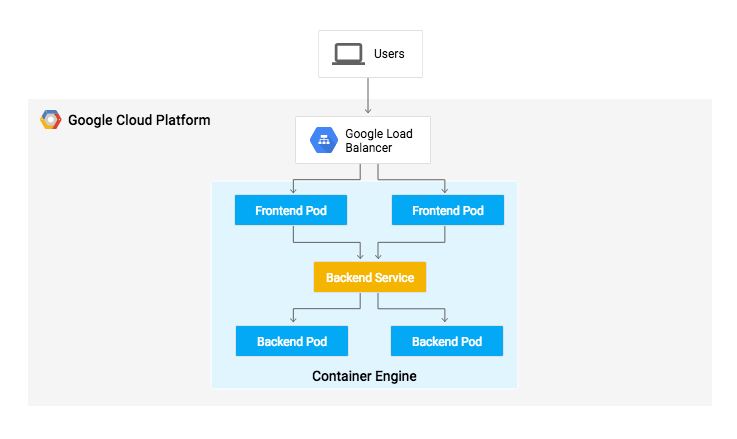

## 5.4 Application 배포

두가지 다른 환경에서 시스템을 배포할 예정입니다.
   * **Production**: live system
   * **Canary(카나리아)**: 정식 릴리즈 하기전에 사용자 반응을 살펴보고, 프로그램 점검을 위한 환경 

**#27. 샘플 시스템이 있는곳으로 이동 합니다.**  
cd sample-app  

**#28. deployment 용 namespace 를 생성합니다.**  
kubectl create ns production
***
namespace "production" created

**#29. Production 용 deployment 를 생성합니다.**  
kubectl apply -f k8s/production -n production
***
deployment "gceme-backend-production" created  
deployment "gceme-frontend-production" created

**#30. 카나리아 용 deployment 를 생성합니다.**  
kubectl apply -f k8s/canary -n production
***
deployment "gceme-backend-canary" created  
deployment "gceme-frontend-canary" created

**#31. Service 용 deployment 를 생성합니다.**  
kubectl apply -f k8s/services -n production
***
service "gceme-backend" created  
service "gceme-frontend" created

**#32 Production 환경의 front-end 를 scale-up 합니다.**  
kubectl scale deployment gceme-frontend-production -n production --replicas 4
***

deployment "gceme-frontend-production" scaled

\[참조\] 기본으로 frontend 는 1개의 replica 만 deploy 됩니다. kubectl scale 명령어는 항상 4개의 replicas 가 실행되도록 합니다. 

**#33. 이제 front-end 는 5개 (production 4, canary 1) 가 실행되어야 만 합니다. (카나리아는 5개중에서 1개 20% 사용합니다) 이것을 확인 합니다.**  
kubectl get pods -n production -l app=gceme -l role=frontend
***
<pre>
NAME                                         READY     STATUS    RESTARTS   AGE
gceme-frontend-canary-6fd798d955-rtpqk       1/1       Running   0          8m
gceme-frontend-production-78bc654ff6-48wzk   1/1       Running   0          6m
gceme-frontend-production-78bc654ff6-4wz7g   1/1       Running   0          9m
gceme-frontend-production-78bc654ff6-dq66q   1/1       Running   0          6m
gceme-frontend-production-78bc654ff6-txzj7   1/1       Running   0          6m
</pre>

**#34. back-end 용으로 2개의 pods 를 확인합니다.**  
kubectl get pods -n production -l app=gceme -l role=backend
***
<pre>
NAME                                       READY     STATUS    RESTARTS   AGE
gceme-backend-canary-5d9747794c-8cjqs      1/1       Running   0          11m
gceme-backend-production-67dbc6bcd-vrlt8   1/1       Running   0          11m
</pre>

**#35. Production Service 의 외부 ip 주소를 확인합니다.**  
\[이 작업은 load balancer 의 ip 를 얻기까지 수분 정도 걸립니다.\]  
kubectl get service gceme-frontend -n production
***
<pre>
NAME             TYPE           CLUSTER-IP      EXTERNAL-IP      PORT(S)        AGE
gceme-frontend   LoadBalancer   10.11.249.119   104.198.46.251   80:32208/TCP   14m
</pre>

**#36 load balancer 의 외부 ip 주소는 자주 사용하므로 환경변수에 저장합니다.**  
export FRONTEND_SERVICE_IP=\$(kubectl get -o jsonpath="{.status.loadBalancer.ingress[0].ip}" --namespace=production services gceme-frontend)
***

**#37. front-end, back-end 서비스가 작동되는지 브라우저하고 콘솔 명령어 상에서 실행해 봅니다.**  
curl http://\$FRONTEND_SERVICE_IP/version
***
1.0.0

브라우저 하고 콘솔 상에서 값이 1.0.0 이나오면 정성적으로 deploy 된것입니다.

## 5.5 Jenkins Pipeline 설정
(소스부터 빌드 배포 까지 일련의 작업을 pipeline 이라고 하는것 같음)

### 5.5.1 sample apps 소스코드 레포지터리 생성

로컬로 git 을 생성하고, gceme sample code 를 copy 한 후에 [Cloud Source Repositories](https://cloud.google.com/source-repositories/docs/) 에 push 합니다.

**#38. alpha 버젼 git repository 를 생성합니다.**  
gcloud alpha source repos create default
***
<pre>
ERROR: (gcloud.alpha.source.repos.create) ResponseError: status=[PERMISSION_DENIED], code=[403], message=[User [riveroaks.jung@gmail.com] does not have permission to access project [jenkins-kube-195808] (or it may not exist): The caller does not have permission].
details:
- Cloud Source Repositories API is not enabled. Please enable the API on the Google Cloud console.
enable at: https://console.cloud.google.com/apis/library/sourcerepo.googleapis.com/?project=jenkins-kube-195808
</pre>

에러발생후에 위 url를 타고 들어가서 api enable 한 후에 재실행
***
<pre>
Created [default].
WARNING: You may be billed for this repository. See https://cloud.google.com/source-repositories/docs/pricing for details.
</pre>

**#39. git 초기화**  
git init
***
Initialized empty Git repository in /home/riveroaks_jung/jenkins/continuous-deployment-on-kubernetes/sample-app/.git/

**40. git repository 초기값 설정**   
git config credential.helper gcloud.sh
***



**#41. remote git repository 초기화**  
\[PROJECT_ID\]: jenkins-kube-195808  
git remote add origin https://source.developers.google.com/p/jenkins-kube-195808/r/default
***


**#42. commit 용으로 username 과 email 주소를 설정**  
git config --global user.email "\[EMAIL_ADDRESS\]"  
git config --global user.name "\[USERNAME\]"
***

.git/config 파일을 보면
<pre>
[sample-app]$ cat .git/config
[core]
        repositoryformatversion = 0
        filemode = true
        bare = false
[credential]
        helper = gcloud.sh
[remote "origin"]
        url = https://source.developers.google.com/p/jenkins-kube-195808/r/default
        fetch = +refs/heads/*:refs/remotes/origin/*
</pre>

**#43. gceme sample app 소스를 추가, commit 한 후에 remote git 에 push 함.**  
git add .  
git commit -m "Initial commit"  
***
<pre>
[master (root-commit) 9d5fa60] Initial commit
 14 files changed, 723 insertions(+)
 create mode 100644 Dockerfile
 create mode 100644 Jenkinsfile
 create mode 100644 html.go
 create mode 100644 k8s/canary/backend-canary.yaml
 create mode 100644 k8s/canary/frontend-canary.yaml
 create mode 100644 k8s/dev/backend-dev.yaml
 create mode 100644 k8s/dev/default.yml
 create mode 100644 k8s/dev/frontend-dev.yaml
 create mode 100644 k8s/production/backend-production.yaml
 create mode 100644 k8s/production/frontend-production.yaml
 create mode 100644 k8s/services/backend.yaml
 create mode 100644 k8s/services/frontend.yaml
 create mode 100644 main.go
 create mode 100644 main_test.go
 </pre>


**#44. remote repo 에 push**  
git push origin master
***
<pre>
Counting objects: 21, done.
Compressing objects: 100% (21/21), done.
Writing objects: 100% (21/21), 5.95 KiB | 0 bytes/s, done.
Total 21 (delta 9), reused 0 (delta 0)
remote: Resolving deltas: 100% (9/9)
To https://source.developers.google.com/p/jenkins-kube-195808/r/default
 * [new branch]      master -> master
</pre>

### 5.5.2 Add service account credentials on Jenkins

**#45. Jenkins 이 source repo 에 접근하기 위한 credentials 설정**  

Step 1 - 왼쪽 메뉴에서 **Credential** 를 클릭함.  
Step 2 - 위쪽 그룹에서 **Jenkins** 을 선택함.
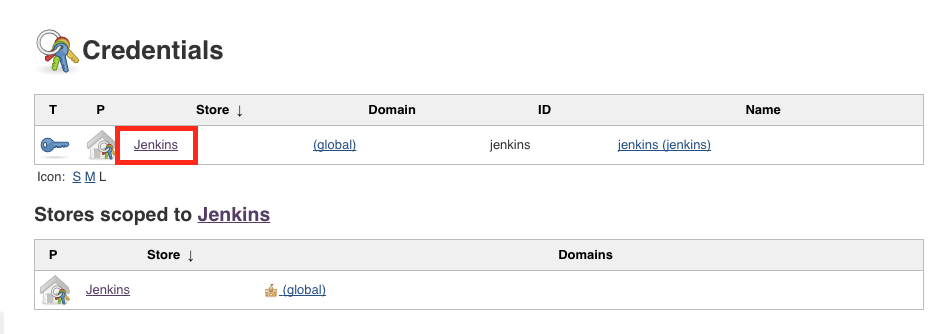

Step 3 - **Global credentials (unrestricted)** 를 클릭함.  
Step 4 - 왼쪽 메뉴에서 **Add Credential** 을 선택함.  
Step 5 - **Kind** Top-down 메뉴에서 **Google Service Account from metadata** 를 선택함.  
Step 6 - **OK**  클릭함.  

### 5.5.3 Jenkins job 생성

**#46. 소스 repo 에서 가져와서 빌드 하고 배포하는 작업 설정**  

Step 1 - **Jenkins&gt;New Item(새로운 Item)** 클릭
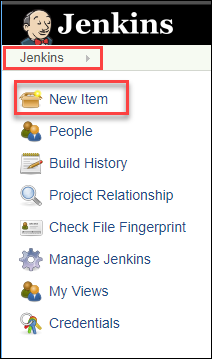

Step 2 - 프로젝트 이름을 **sample-app**, **Multibranch Pipeline** 옵션 선택후에 **OK** 클릭
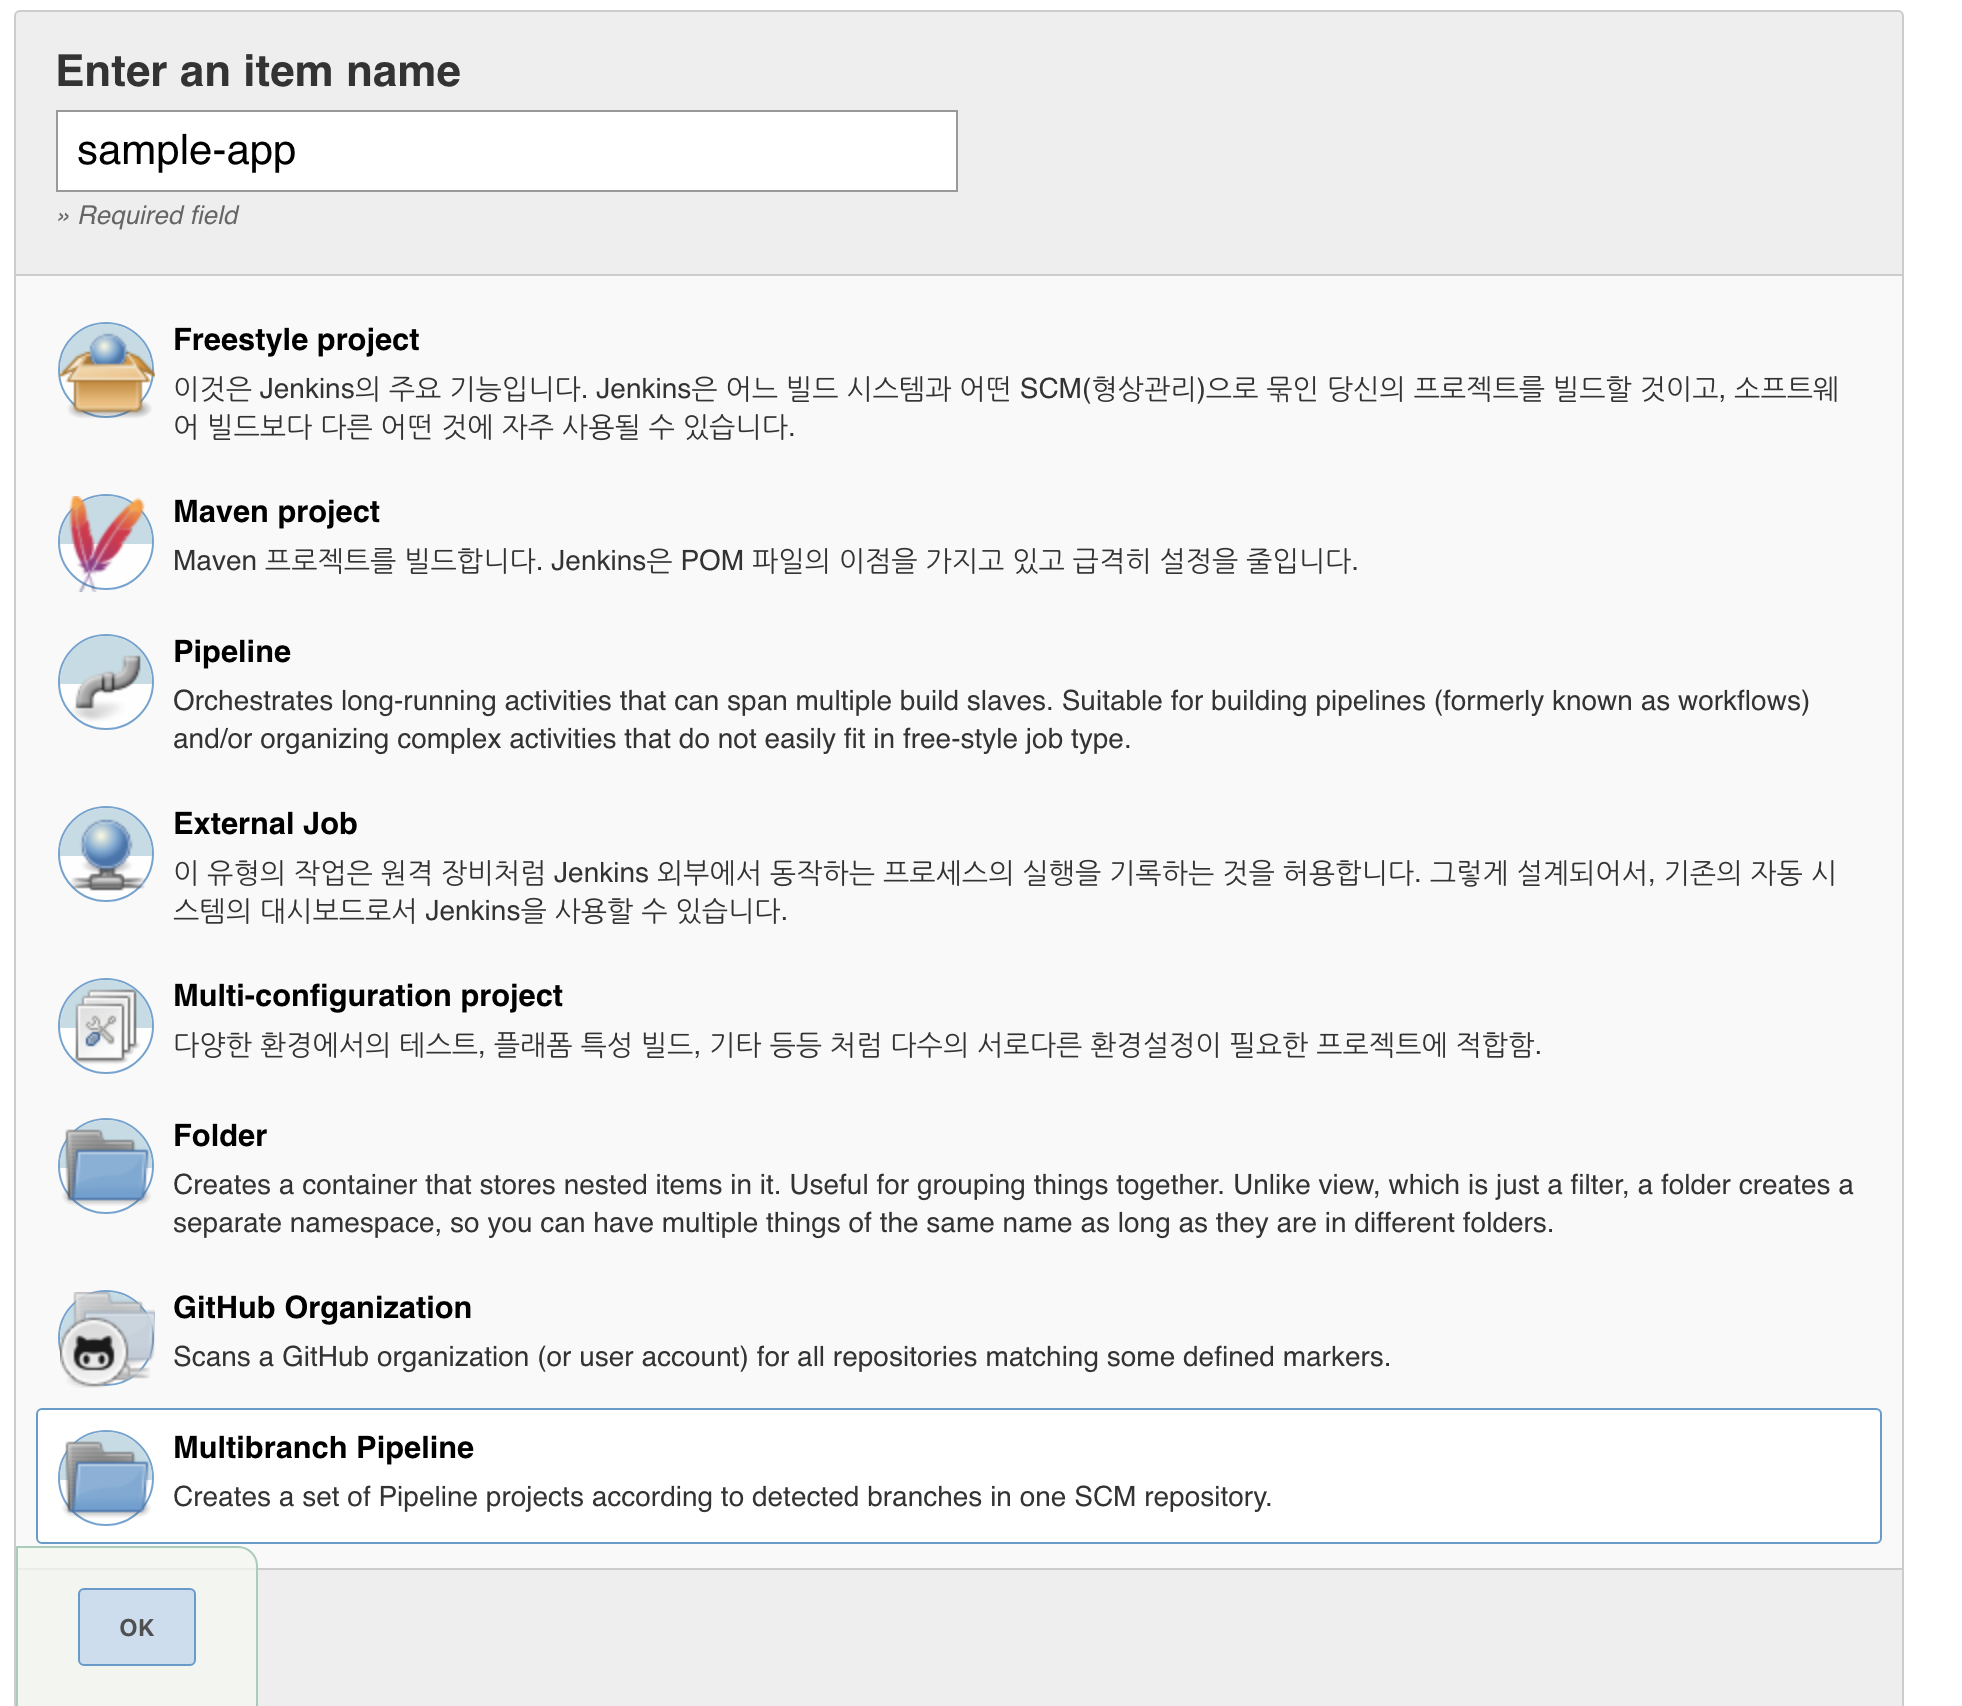

Step 3 - 다음 페이지에서 **Branch Source** 섹션에서 **Add Source** 를 선택하고 **git** 을 선택한다.  
Step 4 - https://source.developers.google.com/p/[PROJECT_ID]/r/defaultcopy-paste 을 **Project Repository** 필드에 copy-paste 하세요. \[PROJECT_ID\] 는 구글 프로젝트 아이디로 바꾸세요.  
Step 5 - **Credentials** drop-down 메뉴에서 이전에 생성한 credentials 를 선택하세요.  
Step 6 - **Build Triggers** (빌드유발) 에서는 **Build Periodically** 를 선택 한 후 박스에는 **\* \* \* \* \*** 다섯갯의 별표를 입력하세요. 이것은 Scheduling 하는 CROM 표현 입니다. \* 와 \* 사이에는 space 가 있습니다.

Step 7 - 최종 모습은 다음과 같습니다. 확인 후에 **Save** 를 클릭합니다.
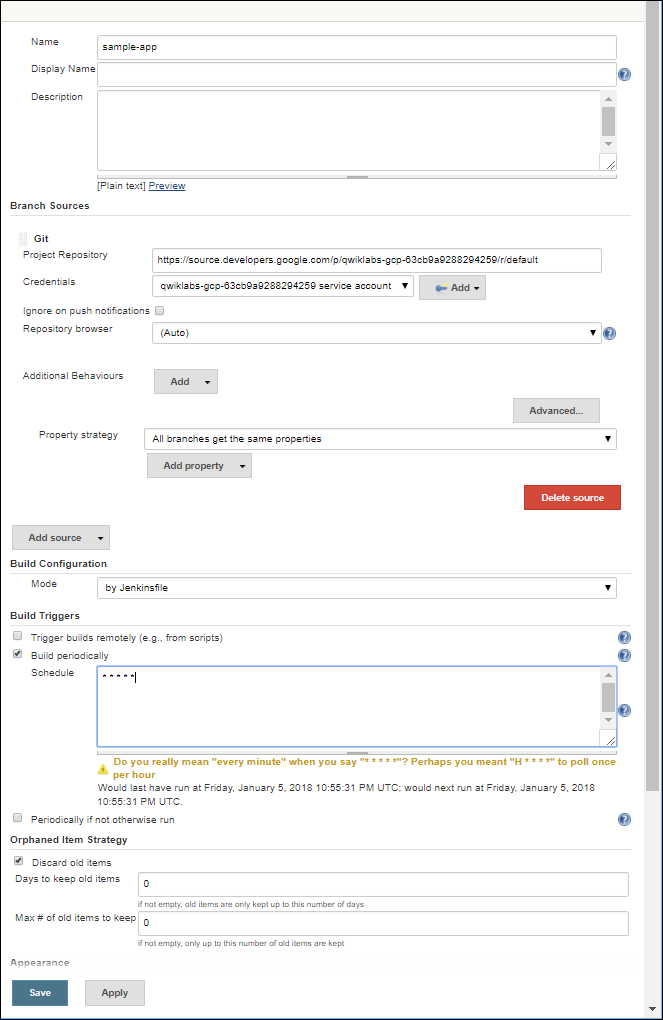

설정이 완료 되고 **Save** 를 클릭하면 "Branch indexing" 이란 job 이 실행됩니다. 이 meta-job 은 repository 에서 branch 를 확인 합니다.

### 5.6 개발 환경 설정 (Development Environment)

개발 branch 는 live 로 통합하기 전에 개발자가 코드를 테스트 하는 것을 말합니다. 따라서 live 환경과 완전히 같아야 합니다. 다른점은 live 사이트에 비해서 scale down 되어 있다는 것입니다.

먼저 development branch 를 생성합니다.

#### 5.6.1 Development Branch 생성

**#47. git 서버에 develop branch 를 생성합니다.**  
git checkout -b new-feature
***
Switched to a new branch 'new-feature'

#### 5.6.2 Pipeine 정의 수정

jankins 파일은 [Jenkins Pipeline Groovy syntax](https://jenkins.io/doc/book/pipeline/) 로 만들어져 있습니다. Jenkinsfile 은 전 빌드 파이프 라인을 하나의 파일에 정의 합니다. 또한 사용자 매뉴얼 승인 또는 전체 병렬화 등 강력한 지원을 합니다. 

따라서 이러한 기능을 사용하기 위해선 Jenkinsfile 의 Project-id 를 설정해야 합니다.

**#48. Jenkinsfile 에서 PROJECT_ID 를 수정하세요**  
***

#### 5.6.3 Site 수정

변화된 것을 보여주기 위해서 gceme cards 를 blud 에서 orange 로 변경

**#49. html.go 파일에서 card blue 를 card orange 와 main.go 에서 version 1.0.0 을 2.0.0 으로 바꾸세요.**  
***

### 5.7 Kick off development

변경된 모든것을 repo 에 반영하세요.

**#50. 변경된것 모든것을 반영하세요.**  
git add Jenkinsfile html.go main.go  
git commit -m "Version 2.0.0"
***
<pre>
[new-feature d5137ad] Version 2.0.0
 3 files changed, 3 insertions(+), 3 deletions(-)
</pre>

***
git push origin new-feature
***
<pre>
Counting objects: 5, done.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 551 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
To https://source.developers.google.com/p/jenkins-kube-195808/r/default
 * [new branch]      new-feature -> new-feature
</pre>

Repo 가 변경되면 빌드가 시작합니다. Jenkins 사용자 화면에서 new-feature branch 가 시작합니다. 
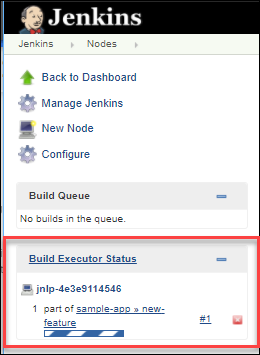

빌드가 끝나면 **Console Output** 을 보면 kubectl ==namespace=new-feature apply ...  라는 메세지를 확인하세요. 이것은 new-feature branch 가 클러스터에 배포되기 시작하는 것입니다.


개발환경은 public-domain load balancer 를 사용하지 말하야 합니다. 보안 이유가 있으므로 Proxy 인증을 사용하도록 합니다.

**#51, proxy 를 백그라운드로 실행합니다.**  
kubectl proxy&
***
\[1\] 4913
\[sample-app\]\$ Starting to serve on 127.0.0.1:8001

**#52. 확인 하시기 바랍니다.**  
curl http://localhost:8001/api/v1/proxy/namespaces/new-feature/services/gceme-frontend:80/version


2.0.0 이 나오면 성공입니다.

### 5.8 카나리아 Release Deploying

카나리아 환경에서 코드를 배포한다.

**#53 canary branch 를 만들고 git server 에 push 합니다.**  
git checkout -b canary
***
Switched to a new branch 'canary'
***
git push origin canary
***
<pre>
Total 0 (delta 0), reused 0 (delta 0)
To https://source.developers.google.com/p/jenkins-kube-195808/r/default
 * \[new branch\]      canary -> canary
</pre>

**#36번 코드 참조 **  
export FRONTEND_SERVICE_IP=$(kubectl get -o jsonpath="{.status.loadBalancer.ingress[0].ip}" --namespace=production services gceme-frontend)

**#54 카나리아 ip 가 version 2.0.0 으로 5개중에 1나는 나타나는지 확인 **  
while true; do curl http://\$FRONTEND_SERVICE_IP/version; sleep 1; done
***
종료는 Ctrl-C

### 5.9 Production Deploying

카라리아 버젼이 성공적으로 완료되고, 고객으로 부터 카나리아에 대한 문제점이 발견이 안되면 프로덕션으로 migration 합니다.

**#55 canary verion 을 merge 해서 production 에 올린다.** 
git checkout master
***
Switched to branch 'master'

***
git merge canary
***
<pre>
Updating 9d5fa60..d5137ad
Fast-forward
 Jenkinsfile | 2 +-
 html.go     | 2 +-
 main.go     | 2 +-
 3 files changed, 3 insertions(+), 3 deletions(-)
</pre>
***
git push origin master
***
<pre>
Total 0 (delta 0), reused 0 (delta 0)
To https://source.developers.google.com/p/jenkins-kube-195808/r/default
   9d5fa60..d5137ad  master -> master
</pre>

**#56 최종적으로 버젼 확인**  
while true; do curl http://\$FRONTEND_SERVICE_IP/version; sleep 1; done
***
종료는 Ctrl-C